# How to train and tune a random forest

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from pathlib import Path
import numpy as np
from numpy.random import choice, normal
import pandas as pd
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
from sklearn.externals import joblib

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('whitegrid')
np.random.seed(seed=42)

## Get Data

In [5]:
with pd.HDFStore('data.h5') as store:
    data =store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56756 entries, ('A', Timestamp('2010-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            56756 non-null  float64
 1   bb_down        56756 non-null  float64
 2   bb_high        56756 non-null  float64
 3   bb_low         56756 non-null  float64
 4   bb_mid         56756 non-null  float64
 5   bb_up          56756 non-null  float64
 6   macd           56756 non-null  float64
 7   natr           56756 non-null  float64
 8   rsi            56756 non-null  float64
 9   sector         56756 non-null  object 
 10  return_1m      56756 non-null  float64
 11  return_3m      56756 non-null  float64
 12  return_6m      56756 non-null  float64
 13  return_12m     56756 non-null  float64
 14  beta           56756 non-null  float64
 15  SMB            56756 non-null  float64
 16  HML            5675

In [6]:
y = data.target
y_binary = (y > 0).astype(int)
X = pd.get_dummies(data.drop('target', axis=1))

## Random Forests

### Cross-validation parameters

In [7]:
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

### Classifier

In [8]:
rf_clf = RandomForestClassifier(n_estimators=100,             # default changed from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

#### Cross-Validation with default settings

In [9]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.2s finished


In [10]:
np.mean(cv_score)

0.5236329094014294

### Regression RF

In [11]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]
ic = make_scorer(rank_correl)

In [12]:
rf_reg = RandomForestRegressor(n_estimators=100, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [13]:
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.3min remaining:   50.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [14]:
np.mean(cv_score)

0.020939303335652547

## Parameter Tuning

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the notebook [decision_trees](01_decision_trees.ipynb). 

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail). 
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:

### Define Parameter Grid

In [15]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

### Instantiate GridSearchCV

We will use 10-fold custom cross-validation and populate the parameter grid with values for the key configuration settings:

In [16]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

### Fit Classifier

In [17]:
gs_clf.fit(X=X, y=y_binary)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  5.8min finished
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x7f5de3b4ce10>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 250], 'max_depth': [5, 15, None], 'min_samples_leaf': [5, 25, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

#### Persist Result

In [18]:
joblib.dump(gs_clf, 'gridsearch_clf.joblib') 

['gridsearch_clf.joblib']

In [38]:
gs_clf = joblib.load('gridsearch_clf.joblib') 

In [39]:
gs_clf.best_params_

{'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100}

In [40]:
gs_clf.best_score_

0.520548756316895

#### Feature Importance

A random forest ensemble may contain hundreds of individual trees, but it is still possible to obtain an overall summary measure of feature importance from bagged models.

For a given feature, the importance score is the total reduction in the objective function's value, which results from splits based on this feature, averaged over all trees. Since the objective function takes into account how many features are affected by a split, this measure is implicitly a weighted average so that features used near the top of a tree will get higher scores due to the larger number of observations contained in the much smaller number of available nodes. By averaging over many trees grown in a randomized fashion, the feature importance estimate loses some variance and becomes more accurate.

The computation differs for classification and regression trees based on the different objectives used to learn the decision rules and is measured in terms of the mean square error for regression trees and the Gini index or entropy for classification trees.

`sklearn` further normalizes the feature-importance measure so that it sums up to 1. Feature importance thus computed is also used for feature selection as an alternative to the mutual information measures we saw in Chapter 6, The Machine Learning Process (see SelectFromModel in the sklearn.feature_selection module).
In our example, the importance values for the top-20 features are as shown here:

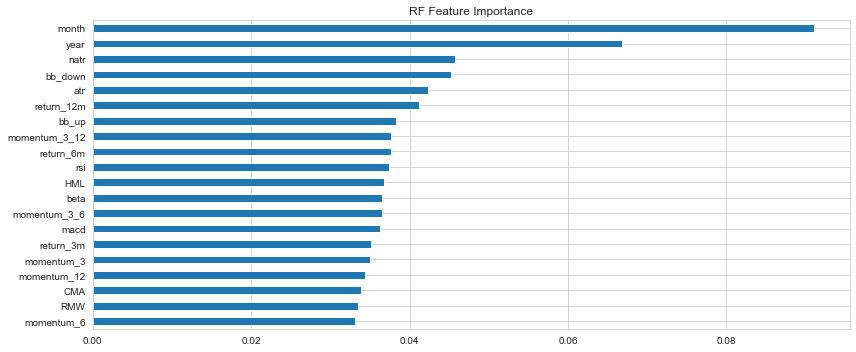

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
fig.tight_layout()
fig.savefig('figures/rf_feature_imp', dpi=300);

### Fit Regressor

In [23]:
gs_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [35]:
gs_reg = gridsearch_reg

In [26]:
gs_reg.fit(X=X, y=y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 27.3min finished
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x7f5de3b4ce10>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 250], 'max_depth': [5, 15, None], 'min_samples_leaf': [5, 25, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rank_correl), verbose=1)

In [27]:
joblib.dump(gs_reg, 'rf_reg_gridsearch.joblib') 

['rf_reg_gridsearch.joblib']

In [28]:
gs_reg = joblib.load('rf_reg_gridsearch.joblib') 

In [36]:
gs_reg.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

In [37]:
f'{gs_reg.best_score_*100:.2f}'

'4.35'

### Compare Results

#### Best Parameters

In [41]:
pd.DataFrame({'Regression': pd.Series(gs_reg.best_params_),
              'Classification': pd.Series(gs_clf.best_params_)})

,Regression,Classification
max_depth,5,15
min_samples_leaf,5,5
n_estimators,100,100


#### Feature Importance

In [31]:
fi_clf = gridsearch_clf.best_estimator_.feature_importances_
fi_reg = gridsearch_reg.best_estimator_.feature_importances_

In [45]:
idx = [c.replace('_', ' ').upper() for c in X.columns]

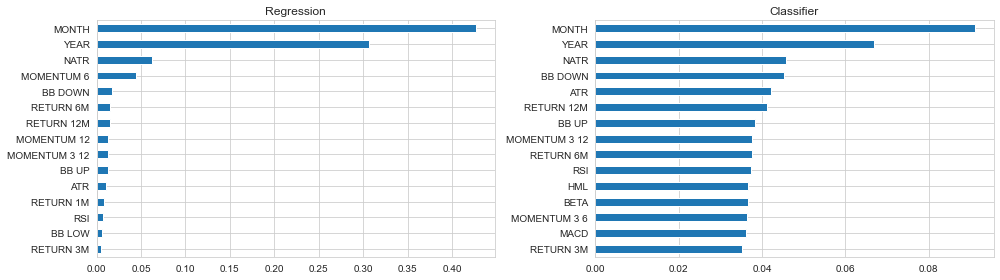

In [47]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
(pd.Series(fi_clf, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[1], title='Classifier'))
(pd.Series(fi_reg, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[0], title='Regression'))
fig.tight_layout()
fig.savefig('figures/rf_feature_imp', dpi=300)